In [1]:
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements(is_chapter2=True)

In [2]:
# !conda install -c conda-forge pyarrow -y

In [3]:
# import pyarrow
# pyarrow.__version__ = '11.0.0'

In [1]:
from datasets import list_datasets 
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification 
from sklearn.metrics import accuracy_score, f1_score 
from transformers import AutoModel 
from transformers import Trainer, TrainingArguments
from transformers import Trainer 
import numpy as np

In [2]:
opp = load_dataset("csv", data_files={'train': '/kaggle/input/opp-dataset/train_new/First Party Collection.csv','valid':'/kaggle/input/opp-dataset/validation/First Party Collection.csv', 'test': '/kaggle/input/opp-dataset/test/First Party Collection.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-20aeac5ef0ffe0c9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# opp = load_dataset("json", data_files="/kaggle/input/opp115wlabel/opp115WLabel.jsonl")

In [3]:
opp

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2353
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 262
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 654
    })
})

In [8]:
# def label_str2int(ds):
#     return ds["train"].features["label"].str2int(ds)
# opp = opp["train"].features["label"].map(label_str2int, batched=True, batch_size=None )

In [3]:
opp = opp.class_encode_column("label")

Casting to class labels:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
# opp = opp['train'].train_test_split(test_size=0.1)

In [6]:
opp

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2353
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 262
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 654
    })
})

In [5]:
opp.set_format(type="pandas") 
df = opp["train"][:] 
def label_int2str(row):
    return opp["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Privacy Policy Sci-News.com is committed to ...,1,nonData Retention
1,Information that Sci-News.com May Collect Onli...,1,nonData Retention
2,"- if you contact us, we may keep a record of t...",0,Data Retention
3,- details of your visits to our site including...,1,nonData Retention
4,Sci-News.com does not knowingly collect or sol...,1,nonData Retention


In [6]:
df['label'].value_counts()

1    2244
0     109
Name: label, dtype: int64

In [7]:
weight = [2244/109,1]

In [8]:
weight

[20.587155963302752, 1]

In [16]:
# def get_label(row):
#     return row['type']
# df["label"] = df["meta"].apply(get_label) 
# df_test["label"] = df_test["meta"].apply(get_label)

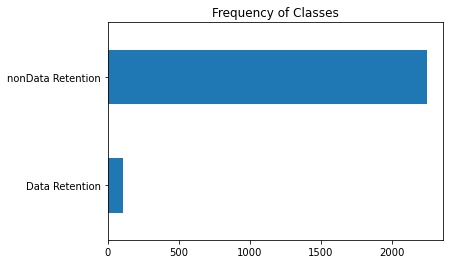

In [9]:
df["label_name"].value_counts(ascending=True).plot.barh() 
plt.title("Frequency of Classes") 
plt.show()

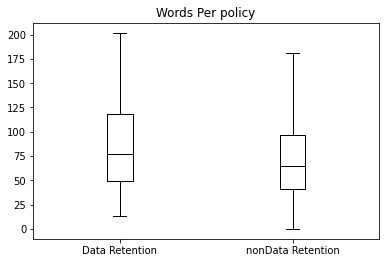

In [10]:
df["Words Per policy"] = df["text"].str.split().apply(len) 
df.boxplot("Words Per policy", by="label_name", grid=False, showfliers=False, color="black") 
plt.suptitle("") 
plt.xlabel("") 
plt.show()

In [11]:
opp.reset_format()

In [9]:
opp

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2353
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 262
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 654
    })
})

In [20]:
# 子词标记化
# model_ckpt = "mukund/privbert" 
model_ckpt = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [22]:
# from transformers import AutoTokenizer 
# model_ckpt = "distilbert-base-uncased" 
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [21]:
def tokenize(batch): 
	return tokenizer(batch["text"], padding=True, truncation=True)

In [22]:
opp_encoded = opp.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
print(opp_encoded["train"].column_names) 

['text', 'label', 'input_ids', 'attention_mask']


In [26]:
# import torch
# torch.cuda.empty_cache()
# import gc
# gc.collect()

In [23]:
# 加载预训练模型
num_labels = 2 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = (AutoModelForSequenceClassification .from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True) .to(device))

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [24]:
#定义性能参数

def compute_metrics(pred): 
	labels = pred.label_ids 
	preds = pred.predictions.argmax(-1) 
	f1 = f1_score(labels, preds, average="macro")
	acc = accuracy_score(labels, preds) 
	return {"accuracy": acc, "f1": f1}

In [18]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        device = 'cuda'
        inputs = inputs.to(device)
#         print(inputs)
        model = model.to(device)
#         print(model)
        labels = inputs.get("labels").to(device)
        # forward pass
        outputs = model(**inputs)
#         outputs = outputs.to(device)
        logits = outputs.get("logits").to(device)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss
#     def compute_loss(self, model, inputs, return_outputs=False):
#         """
#         How the loss is computed by Trainer. By default, all models return the loss in the first element.
#         Subclass and override for custom behavior.
#         """
#         if self.label_smoother is not None and "labels" in inputs:
#             labels = inputs.pop("labels")
#         else:
#             labels = None
#         outputs = model(**inputs)
#         # Save past state if it exists
#         # TODO: this needs to be fixed and made cleaner later.
#         if self.args.past_index >= 0:
#             self._past = outputs[self.args.past_index]

#         if labels is not None:
#             if unwrap_model(model)._get_name() in MODEL_FOR_CAUSAL_LM_MAPPING_NAMES.values():
#                 loss = self.label_smoother(outputs, labels, shift_labels=True)
#             else:
#                 loss = self.label_smoother(outputs, labels)
#         else:
#             if isinstance(outputs, dict) and "loss" not in outputs:
#                 raise ValueError(
#                     "The model did not return a loss from the inputs, only the following keys: "
#                     f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
#                 )
#             # We don't use .loss here since the model may return tuples instead of ModelOutput.
#             loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

#         return (loss, outputs) if return_outputs else loss

            

In [25]:
batch_size = 16 
logging_steps = len(opp_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-finetuned-opp" 
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=10, learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, weight_decay=0.01, evaluation_strategy="epoch", 
                                  disable_tqdm=False, logging_steps=logging_steps, push_to_hub=False, log_level="error", report_to='none' )
# ,load_best_model_at_end=True

In [12]:
opp_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2353
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 262
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 654
    })
})

In [27]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=opp_encoded["train"], eval_dataset=opp_encoded["valid"], tokenizer=tokenizer) 
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.438744,0.832061,0.828053
2,0.441000,0.390201,0.847328,0.845300
3,0.441000,0.447968,0.843511,0.838308
4,0.156100,0.467106,0.854962,0.852171
5,0.156100,0.700916,0.835878,0.835818
6,0.052900,0.734832,0.847328,0.847007
7,0.052900,0.912186,0.824427,0.824335
8,0.017400,0.774957,0.858779,0.858314
9,0.017400,0.772387,0.862595,0.861790
10,0.009300,0.803023,0.862595,0.861944


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

TrainOutput(global_step=740, training_loss=0.13444275044634738, metrics={'train_runtime': 1149.8418, 'train_samples_per_second': 20.464, 'train_steps_per_second': 0.644, 'total_flos': 5574321179957400.0, 'train_loss': 0.13444275044634738, 'epoch': 10.0})

In [21]:
trainer = CustomTrainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=opp_encoded["train"], eval_dataset=opp_encoded["valid"], tokenizer=tokenizer)

In [22]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.520629,0.965649,0.824279
2,0.453800,0.539749,0.954198,0.773618
3,0.453800,0.785120,0.961832,0.797652
4,0.205900,0.611352,0.965649,0.835737
5,0.205900,0.884387,0.965649,0.810982
6,0.082300,0.624532,0.965649,0.835737
7,0.082300,0.642944,0.961832,0.823212
8,0.032100,0.669423,0.965649,0.835737
9,0.032100,0.722309,0.969466,0.849078
10,0.012700,0.682730,0.965649,0.835737


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

TrainOutput(global_step=740, training_loss=0.1563097860261395, metrics={'train_runtime': 998.9061, 'train_samples_per_second': 23.556, 'train_steps_per_second': 0.741, 'total_flos': 5102740863214800.0, 'train_loss': 0.1563097860261395, 'epoch': 10.0})

In [40]:
# test = trainer.save_model

In [28]:
preds_output = trainer.predict(opp_encoded["test"] )

/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [24]:
preds_output.metrics 

{'test_loss': 0.9927334785461426,
 'test_accuracy': 0.963302752293578,
 'test_f1': 0.8236245954692557,
 'test_runtime': 7.2795,
 'test_samples_per_second': 89.841,
 'test_steps_per_second': 2.885}

In [29]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [26]:
def measure_func(yvalid, predictions, lbl_enc):
    decod_predictions = lbl_enc.inverse_transform(predictions)
    decod_yvalid = lbl_enc.inverse_transform(yvalid)
    report = classification_report(decod_yvalid, decod_predictions)
    print(report)

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


In [28]:
labels = opp["test"].features["label"].names 

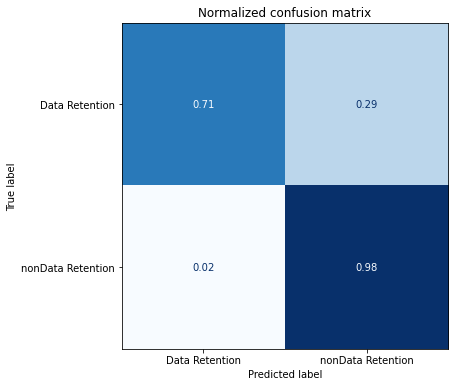

In [29]:
y_test = np.array(opp["test"]["label"]) 
plot_confusion_matrix(y_preds, y_test, labels)

In [30]:
from sklearn.metrics import classification_report
y_test = np.array(opp["test"]["label"]) 
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       317
           1       0.84      0.88      0.86       337

    accuracy                           0.85       654
   macro avg       0.85      0.85      0.85       654
weighted avg       0.85      0.85      0.85       654



In [ ]:
preds_output = trainer.predict(opp_encoded["valid"] )
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(opp["valid"]["label"]) 
labels = opp["valid"].features["label"].names 
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
# #可视化
# model_ckpt = "distilbert-base-uncased" 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# model = AutoModel.from_pretrained(model_ckpt).to(device)
# def extract_hidden_states(batch): # Place model inputs on the GPU 
# 	inputs = {
# 	k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names
# 	} # Extract last hidden states 
# 	with torch.no_grad(): 
# 		last_hidden_state = model(**inputs).last_hidden_state # Return vector for [CLS] token 
# 	return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [ ]:
# opp_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [ ]:
# opp_hidden = opp_encoded.map(extract_hidden_states, batched=True)

In [ ]:
# import numpy as np 
# X_train = np.array(emotions_hidden["train"]["hidden_state"]) 
# X_valid = np.array(emotions_hidden["test"]["hidden_state"]) 
# y_train = np.array(emotions_hidden["train"]["label"]
# y_valid = np.array(emotions_hidden["test"]["label"]) 


# X_train.shape, X_valid.shape ((16000, 768), (2000, 768))
